In [19]:
# Cell 2: Imports & basic setup

import random
from collections import deque

import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "mps"
print("Using device:", device)


Using device: mps


In [20]:
# Cell 3: Replay buffer and Q-network

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states      = np.array(states, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        actions     = np.array(actions, dtype=np.int64)
        rewards     = np.array(rewards, dtype=np.float32)
        dones       = np.array(dones, dtype=np.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
        )

    def forward(self, x):
        return self.net(x)


In [21]:
# Cell 4: Agent that can do DQN or DDQN depending on use_ddqn flag

class Agent:
    def __init__(
        self,
        state_dim,
        action_dim,
        use_ddqn=False,
        gamma=0.99,
        lr=3e-4,
        batch_size=64,
        buffer_capacity=100_000,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        target_update_every=30,
        device=None,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.use_ddqn = use_ddqn

        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay= epsilon_decay
        self.target_update_every = target_update_every

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Online + target networks
        self.q_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.train_steps = 0

    def select_action(self, state, explore=True):
        # epsilon-greedy
        if explore and random.random() < self.epsilon:
            return random.randrange(self.action_dim)

        state_t = torch.as_tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state_t)
            action = int(torch.argmax(q_values, dim=1).item())
        return action

    def update(self):
        # replay warmup – wait until we have enough diverse data
        if len(self.replay_buffer) < max(self.batch_size, 1000):
            return None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states_t      = torch.as_tensor(states, dtype=torch.float32, device=self.device)
        next_states_t = torch.as_tensor(next_states, dtype=torch.float32, device=self.device)
        actions_t     = torch.as_tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards_t     = torch.as_tensor(rewards, dtype=torch.float32, device=self.device)
        dones_t       = torch.as_tensor(dones, dtype=torch.float32, device=self.device)

        # Q(s,a) for taken actions
        q_values = self.q_net(states_t).gather(1, actions_t).squeeze(1)

        with torch.no_grad():
            if self.use_ddqn:
                # --- DDQN target ---
                # 1) Online net selects best action at next state
                next_q_online = self.q_net(next_states_t)  # Q_theta(s', a)
                next_actions  = torch.argmax(next_q_online, dim=1, keepdim=True)

                # 2) Target net evaluates that action
                next_q_target = self.target_net(next_states_t).gather(1, next_actions).squeeze(1)
            else:
                # --- Plain DQN target ---
                # target net both selects and evaluates best next action
                next_q_target = self.target_net(next_states_t).max(dim=1)[0]

            target_q = rewards_t + self.gamma * next_q_target * (1.0 - dones_t)

        loss = nn.MSELoss()(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1.0)
        self.optimizer.step()

        self.train_steps += 1
        if self.train_steps % self.target_update_every == 0:
            self.update_target_net()

        return float(loss.item())

    def update_target_net(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


In [22]:
# Cell 5: Training loop for CartPole or Acrobot with DQN / DDQN

def get_env_defaults(env_name: str):
    """
    Returns (max_steps_per_episode, solved_score) defaults for supported envs.
    """
    if "CartPole" in env_name:
        # reward +1 per timestep, max ~500
        return 500, 450.0   # solved if avg >= 450
    elif "Acrobot" in env_name:
        # reward -1 per timestep, best ~ -100 or better
        return 500, -100.0  # solved if avg >= -100 (less negative)
    else:
        # generic fallback
        return 1000, 200.0


def train_agent(
    env_name="CartPole-v1",
    use_ddqn=False,
    num_episodes=500,
    max_steps_per_episode=None,
    solved_score=None,
    print_every=10,
):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # defaults per environment if not provided
    default_max_steps, default_solved = get_env_defaults(env_name)
    if max_steps_per_episode is None:
        max_steps_per_episode = default_max_steps
    if solved_score is None:
        solved_score = default_solved

    # slightly different epsilon end for harder env (Acrobot)
    if "Acrobot" in env_name:
        eps_end = 0.05
    else:
        eps_end = 0.05

    agent = Agent(
        state_dim=state_dim,
        action_dim=action_dim,
        use_ddqn=use_ddqn,
        gamma=0.99,
        lr=5e-4,
        batch_size=64,
        buffer_capacity=100_000,
        epsilon_start=1.0,
        epsilon_end=eps_end,
        epsilon_decay=0.995,
        target_update_every=20,
        device=device,
    )

    algo_name = "DDQN" if use_ddqn else "DQN"
    print(f"Training {algo_name} on {env_name} for up to {num_episodes} episodes")

    scores = []
    moving_avgs = []
    eps_history = []

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        total_reward = 0.0

        for t in range(max_steps_per_episode):
            action = agent.select_action(state, explore=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(state, action, reward, next_state, done)
            loss = agent.update()

            state = next_state
            total_reward += reward

            if done:
                break

        scores.append(total_reward)
        moving_avg = np.mean(scores[-10:])
        moving_avgs.append(moving_avg)

        agent.decay_epsilon()
        eps_history.append(agent.epsilon)

        if episode % print_every == 0:
            print(
                f"[{algo_name} | {env_name}] "
                f"Ep {episode:4d} | "
                f"Score: {total_reward:7.2f} | "
                f"Avg(10): {moving_avg:7.2f} | "
                f"Eps: {agent.epsilon:.3f}"
            )

        # stop condition based on moving average
        if episode >= 10 and moving_avg >= solved_score:
            print(
                f"[{algo_name} | {env_name}] "
                f"Solved in {episode} episodes, moving average = {moving_avg:.2f}"
            )
            break

    env.close()

    # Plot scores
    plt.figure()
    plt.plot(scores, label="Score per episode")
    plt.plot(moving_avgs, label="Moving average (last 10)")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title(f"{algo_name} on {env_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{algo_name}_{env_name}_scores.png", dpi=150)
    plt.show()

    # Plot epsilon decay
    plt.figure()
    plt.plot(eps_history)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title(f"Epsilon decay ({algo_name} on {env_name})")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{algo_name}_{env_name}_epsilon.png", dpi=150)
    plt.show()

    return agent, scores, moving_avgs


In [23]:
# Cell 6: GIF generation for a trained agent

def make_gif(
    agent: Agent,
    env_name: str,
    filename: str,
    max_steps_per_episode: int = None,
    fps: int = 30,
):
    env = gym.make(env_name, render_mode="rgb_array")
    default_max_steps, _ = get_env_defaults(env_name)
    if max_steps_per_episode is None:
        max_steps_per_episode = default_max_steps

    frames = []

    state, _ = env.reset()
    for t in range(max_steps_per_episode):
        # Greedy policy (no exploration)
        action = agent.select_action(state, explore=False)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        frame = env.render()
        frames.append(frame)

        state = next_state
        if done:
            break

    env.close()

    imageio.mimsave(filename, frames, fps=fps)
    print(f"Saved GIF to {filename}")


Training DDQN on Acrobot-v1 for up to 800 episodes
[DDQN | Acrobot-v1] Ep   10 | Score: -500.00 | Avg(10): -490.60 | Eps: 0.951
[DDQN | Acrobot-v1] Ep   20 | Score: -500.00 | Avg(10): -475.50 | Eps: 0.905
[DDQN | Acrobot-v1] Ep   30 | Score: -500.00 | Avg(10): -496.20 | Eps: 0.860
[DDQN | Acrobot-v1] Ep   40 | Score: -500.00 | Avg(10): -482.40 | Eps: 0.818
[DDQN | Acrobot-v1] Ep   50 | Score: -500.00 | Avg(10): -500.00 | Eps: 0.778
[DDQN | Acrobot-v1] Ep   60 | Score: -238.00 | Avg(10): -457.80 | Eps: 0.740
[DDQN | Acrobot-v1] Ep   70 | Score: -232.00 | Avg(10): -427.30 | Eps: 0.704
[DDQN | Acrobot-v1] Ep   80 | Score: -380.00 | Avg(10): -457.50 | Eps: 0.670
[DDQN | Acrobot-v1] Ep   90 | Score: -232.00 | Avg(10): -316.80 | Eps: 0.637
[DDQN | Acrobot-v1] Ep  100 | Score: -169.00 | Avg(10): -362.40 | Eps: 0.606
[DDQN | Acrobot-v1] Ep  110 | Score: -392.00 | Avg(10): -283.30 | Eps: 0.576
[DDQN | Acrobot-v1] Ep  120 | Score: -173.00 | Avg(10): -270.40 | Eps: 0.548
[DDQN | Acrobot-v1] Ep  1

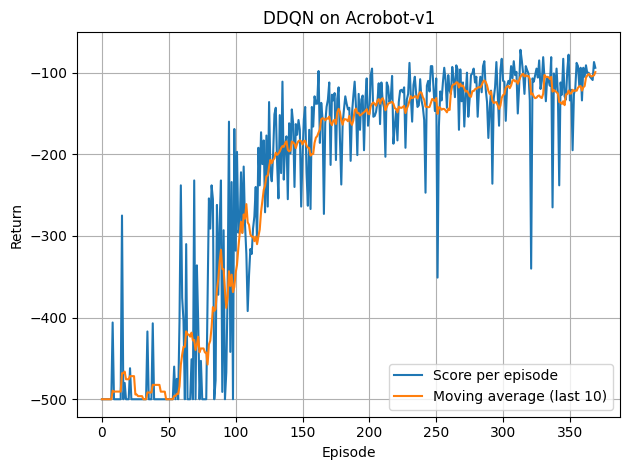

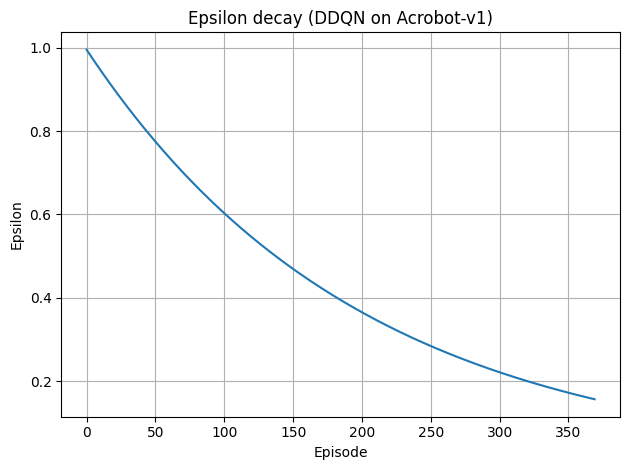

Saved GIF to V4-DDQN-Acrobot-v1.gif


In [25]:
# Cell 7: SELECT ENVIRONMENT + ALGORITHM AND RUN

# Choose environment: "CartPole-v1" or "Acrobot-v1"
ENV_NAME = "Acrobot-v1"   # or "Acrobot-v1"

# Choose algorithm: False = DQN, True = DDQN
USE_DDQN = True            # set to False to run plain DQN

# Training settings
NUM_EPISODES = 800   # you can raise this for Acrobot
PRINT_EVERY = 10

agent, scores, moving_avgs = train_agent(
    env_name=ENV_NAME,
    use_ddqn=USE_DDQN,
    num_episodes=NUM_EPISODES,
    max_steps_per_episode=None,   # use default per env
    solved_score=None,            # use default per env
    print_every=PRINT_EVERY,
)

algo_name = "DDQN" if USE_DDQN else "DQN"
gif_name = f"V4-{algo_name}-{ENV_NAME}.gif"

make_gif(
    agent=agent,
    env_name=ENV_NAME,
    filename=gif_name,
    max_steps_per_episode=None,
    fps=30,
)
